In [63]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from math import exp
from math import log

In [64]:
def parseData(fname):
  for l in urlopen(fname):
    yield eval(l)

In [65]:
print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")

Reading data...
done


In [66]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], \
          datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

In [67]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

In [68]:
##################################################
# Logistic regression by gradient ascent         #
##################################################
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

## Problem 1

In [69]:
import random
random.shuffle(data)
X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

In [70]:
X_train = X[:len(X)//3]     # top 1/3 of the shuffled data
y_train = y[:len(y)//3]
##################################################
# Train                                          #
##################################################

def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

In [71]:
##################################################
# Predict                                        #
##################################################

def performance(theta,X,Y):
  scores = [inner(theta,x) for x in X]
  predictions = [s > 0 for s in scores]
  correct = [(a == b) for (a,b) in zip(predictions,Y)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [72]:
##################################################
# Validation pipeline                            #
##################################################
### training set
lam = 1.0

theta = train(lam)
acc = performance(theta,X_train,y_train)
print("lambda = " + str(lam) + ":\taccuracy of the training set=" + str(acc))    

lambda = 1.0:	accuracy of the training set=0.7224888995559823


In [73]:
### validation set

X_validation=X[len(X)//3:2*len(X)//3]
y_validation=y[len(y)//3:2*len(y)//3]
acc1 = performance(theta,X_validation,y_validation)
print("lambda = " + str(lam) + ":\taccuracy of the validation set=" + str(acc1))  

lambda = 1.0:	accuracy of the validation set=0.7171656566868663


In [74]:
### test set

X_test=X[2*len(X)//3:]
y_test=y[2*len(y)//3:]
acc2 = performance(theta,X_test,y_test)
print("lambda = " + str(lam) + ":\taccuracy of the validation set=" + str(acc2))

lambda = 1.0:	accuracy of the validation set=0.7178856422871542


## Problem 2

In [75]:
### P/N/TP/TN/FP/FN of the test set 
scores2 = [inner(theta,x) for x in X_test]
predictions2 = [s > 0 for s in scores2]

###  positives
nums_positive = sum(predictions2)
print("The number of predicted positives:\t" + str(nums_positive))

### negatives
nums_negative = len(predictions2)-nums_positive
print("The number of predicted negatives:\t" + str(nums_negative))

### True Positives
TP = [(a == b and a == True) for (a,b) in zip(predictions2,y_test)]
nums_TP = sum(TP)
print("The number of True Positives:\t" + str(nums_TP))

### True Negatives
TN = [(a == b and a == False) for (a,b) in zip(predictions2,y_test)]
nums_TN = sum(TN)
print("The number of True Negatives:\t" + str(nums_TN))

### False Positives
FP = [(a == True and b == False) for (a,b) in zip(predictions2,y_test)]
nums_FP = sum(FP)
print("The number of False Positives:\t" + str(nums_FP))

### False Negatives
FN = [(a == False and b == True) for (a,b) in zip(predictions2,y_test)]
nums_FN = sum(FN)
print("The number of False Negatives:\t" + str(nums_FN))

The number of predicted positives:	12350
The number of predicted negatives:	4317
The number of True Positives:	9038
The number of True Negatives:	2927
The number of False Positives:	3312
The number of False Negatives:	1390


## Problem 3

If we want to assign greater importance to False Positives as compared to False Negatives, <br>
 we could reduce the likelihood of FP, that is, case y>0 and logit<0.

In [86]:
##################################################
# Logistic regression by gradient ascent         #
##################################################
# NEGATIVE Log-likelihood
def f_weighted(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
        if logit>0 :
            loglikelihood -= logit*1.4  ## modified place
          #  loglikelihood *= 10
        else :
            loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime_weighted(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        if logit >0 :
           dl[k] -= X[i][k]*1.4
         #  dl[k] *= 10
        else :
           dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

def train_weighted(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f_weighted, [0]*len(X[0]), fprime_weighted, pgtol = 10, \
                                           args = (X_train, y_train, lam))
  return theta

In [87]:
theta1 = train_weighted(lam)
scores_weighted = [inner(theta1,x) for x in X_test]
predictions_weighted = [s > 0 for s in scores_weighted]

### True Positives
TP1 = [(a == b and a == True) for (a,b) in zip(predictions_weighted,y_test)]
nums_TP1 = sum(TP1)
print("The number of True Positives:\t" + str(nums_TP1))

### True Negatives
TN1 = [(a == b and a == False) for (a,b) in zip(predictions_weighted,y_test)]
nums_TN1 = sum(TN1)
print("The number of True Negatives:\t" + str(nums_TN1))

### False Positives
FP1 = [(a == True and b == False) for (a,b) in zip(predictions_weighted,y_test)]
nums_FP1 = sum(FP1)
print("The number of False Positives:\t" + str(nums_FP1))

### False Negatives
FN1 = [(a == False and b == True) for (a,b) in zip(predictions_weighted,y_test)]
nums_FN1 = sum(FN1)
print("The number of False Negatives:\t" + str(nums_FN1))

The number of True Positives:	8418
The number of True Negatives:	3634
The number of False Positives:	2605
The number of False Negatives:	2010


## Problem 4

In [88]:
#### lam = 0
theta_0 = train(0)
acc_0 = performance(theta_0,X_validation,y_validation)
print("lambda = " + str(0) + ":\taccuracy of the validation set=" + str(acc_0))  

### lam = 0.01
theta_1 = train(0.01)
acc_1 = performance(theta_1,X_validation,y_validation)
print("lambda = " + str(0.01) + ":\taccuracy of the validation set=" + str(acc_1)) 

### lam = 0.1
theta_2 = train(0.1)
acc_2 = performance(theta_2,X_validation,y_validation)
print("lambda = " + str(0.1) + ":\taccuracy of the validation set=" + str(acc_2)) 

### lam = 1
theta_3 = train(1)
acc_3 = performance(theta_3,X_validation,y_validation)
print("lambda = " + str(1) + ":\taccuracy of the validation set=" + str(acc_3)) 

### lam = 100
theta_4 = train(100)
acc_4 = performance(theta_4,X_validation,y_validation)
print("lambda = " + str(100) + ":\taccuracy of the validation set=" + str(acc_4)) 

lambda = 0:	accuracy of the validation set=0.7177056458870823
lambda = 0.01:	accuracy of the validation set=0.7177056458870823
lambda = 0.1:	accuracy of the validation set=0.7177656446871062
lambda = 1:	accuracy of the validation set=0.7171656566868663
lambda = 100:	accuracy of the validation set=0.6693466130677387


The best $\lambda$ is 100

In [89]:
acc_train = performance(theta_4,X_train,y_train)
print("lambda = " + str(100) + ":\taccuracy of the train set=" + str(acc_train))
acc_test = performance(theta_4,X_test,y_train)
print("lambda = " + str(100) + ":\taccuracy of the test set=" + str(acc_test))

lambda = 100:	accuracy of the train set=0.6740669626785072
lambda = 100:	accuracy of the test set=0.5965438617544702


# Task 2

## problem 5

In [40]:
### Network visualization ###
import networkx as nx
import matplotlib.pyplot as plt

In [41]:
edges = set()
nodes = set()
for edge in urlopen("http://jmcauley.ucsd.edu/cse258/data/facebook/egonet.txt"):
  x,y = edge.split()
  x,y = int(x),int(y)
  edges.add((x,y))
  edges.add((y,x))
  nodes.add(x)
  nodes.add(y)

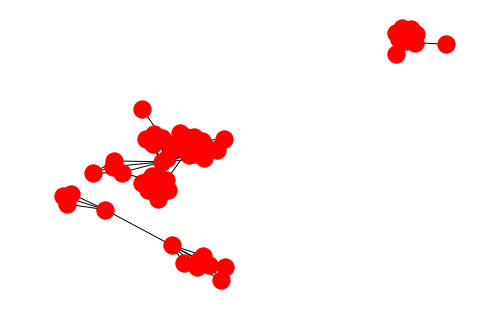

<Figure size 432x288 with 0 Axes>

In [42]:
G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [43]:
### define a dict :group  [ key: node i; value: all node j if (i,j) in edges]
group={}   
for edge in edges :
    if edge[0] in group :
        group[edge[0]].add(edge[1])
    else :
        group[edge[0]]=set([edge[1]])


### use BFS to find all nodes that belongs to one group
def get_all_connected_groups(graph):
    already_seen = set()
    result = []
    for node in graph:
        if node not in already_seen:
            connected_group, already_seen = \
            get_connected_group(graph,node, already_seen)
            result.append(connected_group)
    return result


def get_connected_group(graph,node, already_seen):
        result = []
        nodes = set([node])
        while nodes:
            node = nodes.pop()
            already_seen.add(node)
            nodes.update(graph[node] - already_seen) 
            result.append(node)
        return result, already_seen

components = get_all_connected_groups(group)
#print(components)

print("\n The number of connected components:\t" +str(len(components)))
length = [0]*len(components)
for i in range(len(components)):
    length[i] = len(components[i])
print("The largest component's node number\t"+str(max(length)))



 The number of connected components:	3
The largest component's node number	40


## Problem 6

In [44]:
### new_graph is the largest connected component
new_graph = components[0]
new_graph.sort()

### split new_graph into two parts
graph1 = new_graph[:len(new_graph)//2]
graph2 = new_graph[len(new_graph)//2:]

### find the normalized cut
def norm_cut(graph1,graph2) :
    cut = 0
    degree1 = sum(G.degree(node1) for node1 in graph1)
    degree2 = sum(G.degree(node2) for node2 in graph2)
    for node1 in graph1 :
       for node2 in graph2 :
          if (node1,node2) in edges:
              cut+=1
    Norm_cut=0.5 * (cut/degree1 + cut/degree2)
    return Norm_cut
res = norm_cut(graph1,graph2)
print("The normalized cut cost is: "+ str(res))

The normalized cut cost is: 0.42240587695133147


## Problem 7

In [50]:
# minimize the cost, if new generated cost is higher than the 
# previous one, then stop

old_min_cost = res
new_min_cost = res
while True :
    if old_min_cost < new_min_cost :
        break
    else :
        old_min_cost = new_min_cost
        
    cost = [0] * len(new_graph)
    for i in range(len(new_graph)) :
      g1= graph1.copy()
      g2= graph2.copy()
      if new_graph[i] in g1 :
          g2 += [new_graph[i]]
          del g1[g1.index(new_graph[i])]
      else :
          g1 += [new_graph[i]]
          del g2[g2.index(new_graph[i])]
      cost[i] = norm_cut (g1, g2)
    
    move_point = cost.index(min(cost))

    if new_graph[move_point] in graph1 :
       graph2 += [new_graph[move_point]]
       del graph1[graph1.index(new_graph[move_point])]
    else :
       graph1 += [new_graph[move_point]]
       del graph2[graph2.index(new_graph[move_point])]
    new_min_cost =  min(cost)

print("The normalized cut cost is "+str(old_min_cost))
print("nodes in Community 1: "+str(graph1))
print("nodes in Community 2: "+str(graph2))

### because the content is cut when saving as PDF,
### I will show the result in annotation
### community 1:[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774,
### 800, 803, 805, 810, 811, 819, 828, 823, 830, 840, 880, 890, 869, 856]
### community 2: [825, 861, 863, 864, 876, 878, 882, 884, 
### 886, 888, 889, 893, 729, 804, 798]

The normalized cut cost is 0.09817045961624274
nodes in Community 1: [697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 800, 803, 805, 810, 811, 819, 828, 823, 830, 840, 880, 890, 869, 856]
nodes in Community 2: [825, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893, 729, 804, 798]


## Problem 8

In [55]:
## new_graph : 40 nodes : a connected tcommunity
## all_edge : number of edges in the new_graph
all_edge = sum([G.degree(v) for v in new_graph])/2
#print(all_edge)

## split into two parts
graph_1 = new_graph[:len(new_graph)//2]
graph_2 = new_graph[len(new_graph)//2:]

### compute Q
def q(all_edge, g1, g2):
    count =0
    for i in g1 :
        for j in g2 :
            if (i,j) in edges :
              count += 1
    q_=(all_edge-count)/all_edge
    a = sum([G.degree(v) for v in g1])
    q_ -= (a/(all_edge*2))**2
    a = sum([G.degree(v) for v in g2])
    q_ -= (a/(all_edge*2))**2
    return q_

### Greedy algorithm , when new Q is not increasing, stop.
old_q = new_q = -0.5
while True :
    if old_q > new_q :
        break
    else :
        old_q = new_q
        
    q_list = [0] * len(new_graph)
    for i in range(len(new_graph)) :
       g1 = graph_1.copy()
       g2 = graph_2.copy()
       if new_graph[i] in g1 :
          g2 += [new_graph[i]]
          del g1[g1.index(new_graph[i])]
       else :
          g1 += [new_graph[i]]
          del g2[g2.index(new_graph[i])]
       q_list[i] = q(all_edge, g1, g2)
    
    mp= q_list.index(max(q_list))
    if new_graph[mp] in graph_1 :
       graph_2 += [new_graph[mp]]
       del graph_1[graph_1.index(new_graph[mp])]
    else :
       graph_1 += [new_graph[mp]]
       del graph_2[graph_2.index(new_graph[mp])]
    new_q = max(q_list)
print("Community 1:"+str(graph1))
print("Community 2:"+str(graph2))
print("modularity values for the split: "+str(old_q))

### the two community we found here is the same with that in Problem 7

Community 1:[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 800, 803, 805, 810, 811, 819, 828, 823, 830, 840, 880, 890, 869, 856]
Community 2:[825, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893, 729, 804, 798]
modularity values for the split: 0.3380165289256196
